<a href="https://colab.research.google.com/github/deepenmi/pyTorchPractice/blob/master/CNN_CIFAR10_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms


# GPU/CPU Selection

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data Loader

In [3]:
transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
                                ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

0it [00:00, ?it/s]

170500096it [00:04, 41093878.50it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1,2,0)
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  return image

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

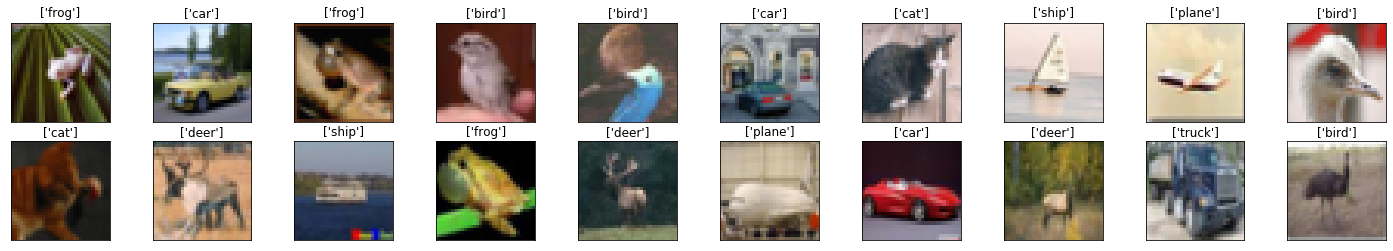

In [6]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2,10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([classes[labels[idx].item()]])

# Convolutional Neural Network

In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    # Convolution Layers
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding =1)      # no. of input channels, no. of output channels, kernel size, stride length
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding =1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding =1)
    # Fully Connected Layers
    self.fc1 = nn.Linear(4*4*64, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*64)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x 

In [8]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [10]:
epochs = 15
running_loss_history = []
running_corrects_history = []

val_running_loss_history=[]
val_running_corrects_history=[]

for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  print(e)
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == labels.data)
    running_loss+=loss.item()
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_running_corrects += torch.sum(val_preds == val_labels.data)
        val_running_loss+=val_loss.item()

    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float() / len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float() / len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print('training loss: {:.4f}, accuracy: {:.4f}'.format(epoch_loss, epoch_acc.item())) 
    print('Validation loss: {:.4f}, accuracy: {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

0
training loss: 1.5772, accuracy: 42.4080
Validation loss: 1.3530, accuracy: 51.2900
1
training loss: 1.2425, accuracy: 55.3360
Validation loss: 1.1525, accuracy: 59.2500
2
training loss: 1.0661, accuracy: 62.0200
Validation loss: 1.0246, accuracy: 63.8900
3
training loss: 0.9463, accuracy: 66.6720
Validation loss: 0.9576, accuracy: 66.9700
4
training loss: 0.8630, accuracy: 69.5440
Validation loss: 0.9156, accuracy: 67.9500
5
training loss: 0.7972, accuracy: 72.0980
Validation loss: 0.9023, accuracy: 68.8800
6
training loss: 0.7361, accuracy: 74.1700
Validation loss: 0.8601, accuracy: 70.1200
7
training loss: 0.6824, accuracy: 76.1100
Validation loss: 0.8640, accuracy: 70.8600
8
training loss: 0.6414, accuracy: 77.4320
Validation loss: 0.8872, accuracy: 70.4900
9
training loss: 0.6028, accuracy: 78.8180
Validation loss: 0.8344, accuracy: 72.0200
10
training loss: 0.5661, accuracy: 79.8060
Validation loss: 0.8486, accuracy: 71.9500
11
training loss: 0.5293, accuracy: 81.1740
Validatio

# Training and validation Loss


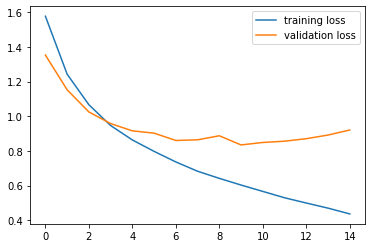

In [11]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history,label='validation loss')
plt.legend()

# Training and Validation Accuracy

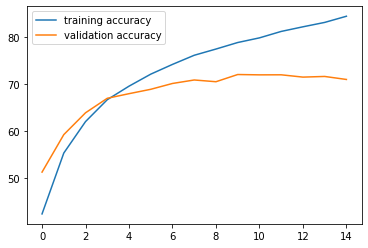

In [12]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history,label='validation accuracy')
plt.legend()

# testing pn Validation dataset

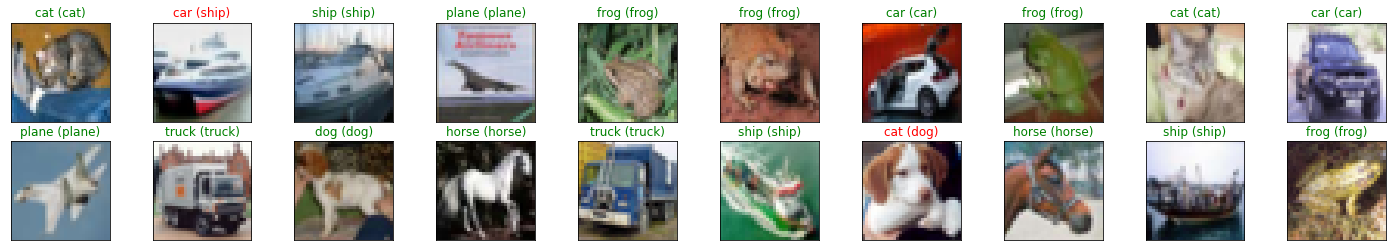

In [13]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
#images_ = images.view(images.shape[0], -1)
outputs = model(images)
_, preds = torch.max(outputs,1)

fig = plt.figure(figsize=(25, 4))
ax.set_title([classes[labels[idx].item()]])
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

# Random Test 1: Image from the web

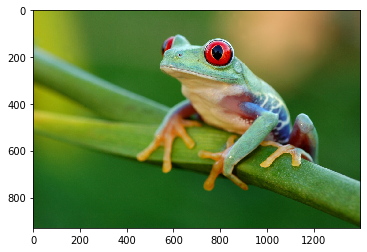

In [14]:
import PIL.ImageOps
import requests
from PIL import Image

url='https://le-www-live-s.legocdn.com/sc/media/lessons/wedo-2/wedo-projects/images/frogs-metamorphosis-project-image-feb9db40c70bcda57e12f5671d4bc278.jpg?fit=inside|1400:1013'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

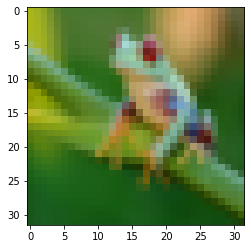

In [15]:
#img = PIL.ImageOps.invert(img)
#img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img))

In [16]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

bird


# Random Test 2: Image from the web

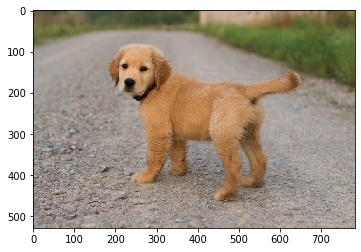

In [17]:
url='https://boygeniusreport.files.wordpress.com/2016/11/puppy-dog.jpg?quality=98&strip=all&w=782'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

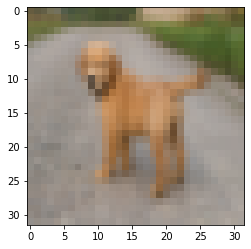

In [18]:
img = transform(img)
plt.imshow(im_convert(img))

In [19]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

dog
